# Part 0: Raw Data & Environment Set-up

## Part 0.a. Raw Data

The following code loads in and unzips the raw data. Raw data has been downloaded from Kaggle placed into public Google Cloud Storage for ease of access. Please note that for local use, smaller subsets of the data stored in .csv files were uploaded directly to the Google collab environment before running the notebook.

In [ ]:
# Loads in steam-reviews.zip (game reviews)
url1 = ("https://storage.googleapis.com/dsc232r-group-project-data/steam-reviews.zip")
!wget "{url1}"

In [ ]:
# Extracts steam-reviews.zip into specified directory and deletes .zip file
!unzip steam-reviews.zip -d /home/joneel/joneel/Group_Project/raw_data/steam-reviews && rm steam-reviews.zip

In [ ]:
# Loads in games.csv (games metadata)
url2 = ("https://storage.googleapis.com/dsc232r-group-project-data/games.csv")
!wget "{url2}"

In [ ]:
# Moves games.csv into specified directory
!mv games.csv /home/joneel/joneel/Group_Project/raw_data

## Part 0.b. Environment Set-up

Set-up on the cluster included 32 cores with 176GB memory in order to load and process this dataset. However, due to issues with the cluster. Final model processing was completed locally on a smaller datset. Therefore, you may see both "local" and "cluster" portions of the code. Particularly regarding the environment set-up.

In [1]:
# Import required libraries
import pickle, glob
import ast
from pyspark.sql import functions as f
from pyspark import StorageLevel
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml.feature import StopWordsRemover
from pyspark.sql.functions import size, collect_list, udf, col, size, avg, count, isnan, when
from pyspark.ml.feature import Word2Vec
from pyspark.sql.types import ArrayType, FloatType, StringType, IntegerType
from pyspark.ml.feature import PCA, VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.functions import array_to_vector
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.linalg import Vectors, VectorUDT

In [2]:
#sc.stop() # To stop a currently running SparkSession, if needed for troubleshooting/development

In [3]:
# Establishes Spark Session (Cluster)
#sc = SparkSession.builder \
    #.config("spark.driver.memory", "22g") \
	  #.config("spark.executor.memory", "22g") \
    #.config("spark.executor.instances", "8") \
    #.config("spark.executor.cores", "4") \
    #.config("spark.sql.shuffle.partitions", "1000") \
	#.appName("MySparkJob") \
	#.getOrCreate()

In [4]:
# Establishes Spark Session (local)

# Install Java and findspark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install -q findspark

# Download Spark from a stable mirror (Updated URL)
!wget -q https://downloads.apache.org/spark/spark-3.4.2/spark-3.4.2-bin-hadoop3.tgz || \
wget -q https://archive.apache.org/dist/spark/spark-3.4.2/spark-3.4.2-bin-hadoop3.tgz
!tar -xzf spark-3.4.2-bin-hadoop3.tgz

# Set environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.2-bin-hadoop3"

# Initialize findspark and SparkSession
import findspark
findspark.init()

from pyspark.sql import SparkSession
sc = SparkSession.builder.master("local[*]").appName("ColabSpark").getOrCreate()

# Part 1: Load Data into Spark Dataframes & Pre-processing

## 1.a. Reviews Data (from [“100 Million+ Steam Reviews”](https://www.kaggle.com/datasets/kieranpoc/steam-reviews/data) dataset)

In [5]:
# Loads all_reviews.csv file into a spark dataframe
#reviews_df = sc.read.csv("/home/joneel/joneel/Group_Project/raw_data/steam-reviews/all_reviews/all_reviews.csv", header=True, inferSchema=True) #Cluster
reviews_df = sc.read.csv("reviews.csv", header=True, inferSchema=True) #Local

In [6]:
# Displays reviews_df schema and counts total # of reviews
#reviews_df.printSchema()
#print(f"Number of reviews: {reviews_df.count()}")

In [7]:
# Removes two columns related to Chinese gaming market (not relevant for this analysis)
reviews_df = reviews_df.drop("hidden_in_steam_china", "steam_china_location")
#reviews_df.printSchema()

In [8]:
# Filters dataframe to include only reviews in English & counts new number of reviews
reviews_df_processed = reviews_df.filter(reviews_df.language == 'english')
#reviews_df_processed.select("language").distinct().show()
#print(f"Number of reviews: {reviews_df_processed.count()}")

In [9]:
# Drops rows that contain null values in the id or reviews column & drop duplicate recommendation ids
reviews_df_processed = reviews_df_processed.na.drop(subset=["recommendationid", "appid", "author_steamid", "review"])
#print(f"Number of reviews: {reviews_df_processed.count()}")
reviews_df_processed = reviews_df_processed.dropDuplicates(subset=["recommendationid"])
#print(f"Number of reviews: {reviews_df_processed.count()}")

In [10]:
# Cast columns to appropriate datatypes based on definitions on Kaggle
reviews_df_processed = reviews_df_processed.withColumn("author_num_games_owned", f.col("author_num_games_owned").cast("integer"))
reviews_df_processed = reviews_df_processed.withColumn("author_num_reviews", f.col("author_num_reviews").cast("integer"))
reviews_df_processed = reviews_df_processed.withColumn("author_playtime_forever", f.col("author_playtime_forever").cast("integer"))
reviews_df_processed = reviews_df_processed.withColumn("author_playtime_last_two_weeks", f.col("author_playtime_last_two_weeks").cast("integer"))
reviews_df_processed = reviews_df_processed.withColumn("author_playtime_at_review", f.col("author_playtime_at_review").cast("integer"))
reviews_df_processed = reviews_df_processed.withColumn("author_last_played", f.from_unixtime(f.col("author_last_played")).cast("timestamp"))
reviews_df_processed = reviews_df_processed.withColumn("timestamp_created", f.from_unixtime(f.col("timestamp_created")).cast("timestamp"))
reviews_df_processed = reviews_df_processed.withColumn("timestamp_updated", f.from_unixtime(f.col("timestamp_updated")).cast("timestamp"))
reviews_df_processed = reviews_df_processed.withColumn("voted_up", f.col("voted_up").cast("integer"))
reviews_df_processed = reviews_df_processed.withColumn("votes_up", f.col("votes_up").cast("integer"))
reviews_df_processed = reviews_df_processed.withColumn("votes_funny", f.col("votes_funny").cast("integer"))
reviews_df_processed = reviews_df_processed.withColumn("weighted_vote_score", f.col("weighted_vote_score").cast("double"))
reviews_df_processed = reviews_df_processed.withColumn("comment_count", f.col("comment_count").cast("integer"))
reviews_df_processed = reviews_df_processed.withColumn("steam_purchase", f.col("steam_purchase").cast("integer"))
reviews_df_processed = reviews_df_processed.withColumn("received_for_free", f.col("received_for_free").cast("integer"))
reviews_df_processed = reviews_df_processed.withColumn("written_during_early_access", f.col("written_during_early_access").cast("integer"))
#reviews_df_processed.printSchema()

In [11]:
# Fixing Boolean columns
reviews_df_processed = reviews_df_processed.filter((reviews_df_processed["steam_purchase"] == 0) | (reviews_df_processed["steam_purchase"] == 1))
reviews_df_processed = reviews_df_processed.filter((reviews_df_processed["received_for_free"] == 0) | (reviews_df_processed["received_for_free"] == 1))
reviews_df_processed = reviews_df_processed.filter((reviews_df_processed["written_during_early_access"] == 0) |
                                                   (reviews_df_processed["written_during_early_access"] == 1))
reviews_df_processed = reviews_df_processed.filter((reviews_df_processed["voted_up"] == 0) | (reviews_df_processed["voted_up"] == 1))
reviews_df_processed = reviews_df_processed.withColumnRenamed("voted_up","positive_review")

# Cast to boolean
reviews_df_processed = reviews_df_processed.withColumn("steam_purchase", f.col("steam_purchase").cast("boolean"))
reviews_df_processed = reviews_df_processed.withColumn("received_for_free", f.col("received_for_free").cast("boolean"))
reviews_df_processed = reviews_df_processed.withColumn("written_during_early_access", f.col("written_during_early_access").cast("boolean"))
reviews_df_processed = reviews_df_processed.withColumn("positive_review", f.col("positive_review").cast("boolean"))

#print(f"Number of reviews: {reviews_df_processed.count()}")

In [12]:
# Filter review dates from before September 12, 2003 (when Steam was launched)
reviews_df_processed = reviews_df_processed.filter(reviews_df_processed.timestamp_created >= '2003-09-12')
reviews_df_processed = reviews_df_processed.filter(reviews_df_processed.timestamp_updated >= '2003-09-12')

In [13]:
# Double check schema and print new review count
#reviews_df_processed.printSchema()
#print(f"Number of reviews: {reviews_df_processed.count()}")

In [14]:
# Splits data into two dataframes, 1 with all the review metadata and 1 with only the recommendationid + appid + review
reviews_df_processed_metadata = reviews_df_processed.drop("review")
reviews_df_processed_reviews = reviews_df_processed.select("recommendationid", "appid", "author_steamid", "review")

## 1.b. Games Data (from ["Steam Games"](https://www.kaggle.com/datasets/artermiloff/steam-games-dataset) dataset)

In [15]:
# Loads games.csv file into a spark dataframe
#games_df = sc.read.csv("/home/joneel/joneel/Group_Project/raw_data/games.csv", header=True, inferSchema=True) # Cluster
games_df = sc.read.csv("games.csv", header=True, inferSchema=True) # Local

In [16]:
# Displays games_df schema and counts total # of games
#games_df.printSchema()
#print(f"Number of games: {games_df.count()}")

In [17]:
# Removes columns not relevant for this analysis
games_df_processed = games_df.drop("reviews", "header_image", "website", "support_url", "support_email", "full_audio_languages", "screenshots", "movies",
                                  "required_age", "metacritic_url", "supported_languages", "packages", "score_rank", "discount")
#games_df_processed.printSchema()

In [18]:
# Drops rows that contain null values or duplicates in the appid column
#print(f"Number of games: {games_df_processed.count()}")
games_df_processed = games_df_processed.na.drop(subset=["appid"])
#print(f"Number of games: {games_df_processed.count()}")
games_df_processed = games_df_processed.dropDuplicates(subset=["appid"])
#print(f"Number of games: {games_df_processed.count()}")

In [19]:
# Cast columns to appropriate data types based ond descriptions on Kaggle
games_df_processed = games_df_processed.withColumn("release_date", f.to_timestamp("release_date", "yyyy-MM-dd"))
games_df_processed = games_df_processed.withColumn("price", f.col("price").cast("double"))
games_df_processed = games_df_processed.withColumn("dlc_count", f.col("dlc_count").cast("integer"))
games_df_processed = games_df_processed.withColumn("windows", f.col("windows").cast("boolean"))
games_df_processed = games_df_processed.withColumn("mac", f.col("mac").cast("boolean"))
games_df_processed = games_df_processed.withColumn("linux", f.col("linux").cast("boolean"))
games_df_processed = games_df_processed.withColumn("metacritic_score", f.col("metacritic_score").cast("double"))
games_df_processed = games_df_processed.withColumn("achievements", f.col("achievements").cast("integer"))
games_df_processed = games_df_processed.withColumn("recommendations", f.col("recommendations").cast("integer"))
games_df_processed = games_df_processed.withColumn("user_score", f.col("user_score").cast("integer"))
games_df_processed = games_df_processed.withColumn("positive", f.col("positive").cast("integer"))
games_df_processed = games_df_processed.withColumn("negative", f.col("negative").cast("integer"))
games_df_processed = games_df_processed.withColumn("average_playtime_forever", f.col("average_playtime_forever").cast("integer"))
games_df_processed = games_df_processed.withColumn("average_playtime_2weeks", f.col("average_playtime_2weeks").cast("integer"))
games_df_processed = games_df_processed.withColumn("median_playtime_forever", f.col("median_playtime_forever").cast("integer"))
games_df_processed = games_df_processed.withColumn("median_playtime_2weeks", f.col("median_playtime_2weeks").cast("integer"))
games_df_processed = games_df_processed.withColumn("pct_pos_total", f.col("pct_pos_total").cast("integer"))
games_df_processed = games_df_processed.withColumn("peak_ccu", f.col("peak_ccu").cast("integer"))
games_df_processed = games_df_processed.withColumn("num_reviews_total", f.col("num_reviews_total").cast("integer"))
games_df_processed = games_df_processed.withColumn("pct_pos_recent", f.col("pct_pos_recent").cast("integer"))
games_df_processed = games_df_processed.withColumn("num_reviews_recent", f.col("num_reviews_recent").cast("integer"))
#games_df_processed.printSchema()

## 1.c. Checking Compatibility of Datasets

In [20]:
# Verify that appid's match between the two datasets
#joined = reviews_df_processed_metadata.select("appid", "game").alias("df1").join(
    #games_df_processed.select("appid", "name").alias("df2"), on="appid", how="inner").filter(
    #"df1.game != df2.name")
#joined.show()

In [21]:
# Dropping the game name from the first dataset (100+ Million Reviews), will use the game name from the second dataset (Steam Games)
reviews_df_processed_metadata = reviews_df_processed_metadata.drop("game")

## 1.d. Final Pre-processed Data Frames

In [22]:
print("Final Processed Dataframes: ")
print("Reviews Metadata (reviews_df_processed_metadata): ")
reviews_df_processed_metadata.printSchema()
print("Reviews (reviews_df_processed_reviews): ")
reviews_df_processed_reviews.printSchema()
print("Games (games_df_processed): ")
games_df_processed.printSchema()

Final Processed Dataframes: 
Reviews Metadata (reviews_df_processed_metadata): 
root
 |-- recommendationid: string (nullable = true)
 |-- appid: integer (nullable = true)
 |-- author_steamid: string (nullable = true)
 |-- author_num_games_owned: integer (nullable = true)
 |-- author_num_reviews: integer (nullable = true)
 |-- author_playtime_forever: integer (nullable = true)
 |-- author_playtime_last_two_weeks: integer (nullable = true)
 |-- author_playtime_at_review: integer (nullable = true)
 |-- author_last_played: timestamp (nullable = true)
 |-- language: string (nullable = true)
 |-- timestamp_created: timestamp (nullable = true)
 |-- timestamp_updated: timestamp (nullable = true)
 |-- positive_review: boolean (nullable = true)
 |-- votes_up: integer (nullable = true)
 |-- votes_funny: integer (nullable = true)
 |-- weighted_vote_score: double (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- steam_purchase: boolean (nullable = true)
 |-- received_for_free: bo

In [23]:
# Save processed dataframes as parquet files
#reviews_df_processed_metadata.write.mode("overwrite").parquet("joneel/Group_Project/processed_data/reviews_processed_metadata")
#reviews_df_processed_reviews.write.mode("overwrite").parquet("joneel/Group_Project/processed_data/reviews_processed")
#games_df_processed.write.mode("overwrite").parquet("joneel/Group_Project/processed_data/games_processed")

In [24]:
# Cache most used dataframe
#reviews_df_processed_metadata.persist(StorageLevel.MEMORY_AND_DISK)
#reviews_df_processed_metadata.count()

# Part 2: Exploratory Plots & Summary Statistics

## 2.a. Summary Statistics

In [ ]:
# Total # Reviews, Total # Games Reviewed, and Total # Unique Reviewers
print(f"Number of Reviews: {reviews_df_processed_metadata.count()}")
num_games_reviewed = reviews_df_processed_metadata.select("appid").distinct().count()
print(f"Number of Games Reviewed: {num_games_reviewed}")
num_unique_reviewers = reviews_df_processed_metadata.select("author_steamid").distinct().count()
print(f"Number of Unique Reviewers: {num_unique_reviewers}")
# Date range of Reviews
print("Date Range of Reviews: ")
reviews_df_processed_metadata.select(f.min("timestamp_created").alias("earliest_review"),
                                     f.max("timestamp_created").alias("latest_review")).show()

## 2.b. Exploratory Plots

In [ ]:
# Review Volume Over Time
# Reduce data to pandas dataframe
reviews_by_month = reviews_df_processed_metadata.withColumn("year_month", f.date_format("timestamp_created", "yyyy-MM"))
review_counts_by_month = reviews_by_month.groupBy("year_month").count().orderBy("year_month")
review_counts_pd = review_counts_by_month.toPandas()
# Line plot - Review Volume Over Time
plt.figure(figsize=(12,6))
plt.plot(review_counts_pd["year_month"], review_counts_pd["count"], marker="o")
plt.xticks(ticks=review_counts_pd.index[::6], labels=review_counts_pd["year_month"][::6], rotation=45, ha="right")
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.title("Monthly Review Volume Over Time")
plt.tight_layout()
plt.show()

In [ ]:
# Plot Most-Reviewed Games (Top 10) - Bar Chart
# Reduce data to pandas dataframe
review_counts = reviews_df_processed_metadata.groupBy("appid").count()
review_counts_named = review_counts.join(games_df_processed.select("appid", "name"), on="appid", how="left")
top_10_games = review_counts_named.orderBy(f.col("count").desc()).limit(10)
top_10_games_pd = top_10_games.toPandas()
# Plot bar chart
plt.figure(figsize=(10,6))
sns.barplot(data=top_10_games_pd, x="name", y="count")
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Most Reviewed Games")
plt.xlabel("Game")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()

In [ ]:
# Plot Most Prolific Reviewers (Top 10) - Bar Chart
# Reduce data to pandas dataframe
reviewer_counts = reviews_df_processed_metadata.groupBy("author_steamid").count()
top_10_reviewers = reviewer_counts.orderBy(f.col("count").desc()).limit(10)
top_10_reviewers_pd = top_10_reviewers.toPandas()
# Plot bar chart
plt.figure(figsize=(10,6))
sns.barplot(data=top_10_reviewers_pd, x="author_steamid", y="count")
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Most Prolific Reviewers")
plt.xlabel("Author's Steam ID")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()

In [ ]:
# Top 10 Best & Worst Reviewed Games
# Reduce data to pandas dataframe
review_stats = reviews_df_processed_metadata.withColumn("positive_review", f.col("positive_review").cast("integer")) \
                    .groupBy("appid") \
                    .agg(
                        f.avg("positive_review").alias("positive_ratio"),
                        f.count("*").alias("total_reviews")
                    )
review_stats_filtered = review_stats.filter("total_reviews >= 10000")
review_stats_named = review_stats_filtered.join(games_df_processed.select("appid", "name"), on="appid", how="left")
review_stats_named = review_stats_named.filter((review_stats_named.name != "None") & (review_stats_named.name.isNotNull()))
top_10_best_games = review_stats_named.orderBy("positive_ratio", ascending=False).limit(10)
top_10_best_games_pd = top_10_best_games.toPandas()
top_10_worst_games = review_stats_named.orderBy("positive_ratio", ascending=True).limit(10)
top_10_worst_games_pd = top_10_worst_games.toPandas()

# Plot bar chart - Top 10 Best Games
plt.figure(figsize=(10,6))
sns.barplot(data=top_10_best_games_pd, x="name", y="positive_ratio")
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Best Reviewed Games")
plt.xlabel("Game")
plt.ylabel("Proportion of Positive Reviews")
plt.ylim(0.975, 1.0)
plt.tight_layout()
plt.show()

# Plot bar chart - Top 10 Worst Games
plt.figure(figsize=(10,6))
sns.barplot(data=top_10_worst_games_pd, x="name", y="positive_ratio")
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Worst Reviewed Games")
plt.xlabel("Game")
plt.ylabel("Proportion of Positive Reviews")
plt.tight_layout()
plt.show()

In [ ]:
# Positivity Rate vs. Playtime at Time of Review
# Reduce data to pandas dataframe
reviews_binned = reviews_df_processed_metadata.withColumn("playtime_bin", f.floor(f.col("author_playtime_at_review") / 100) * 100)
reviews_binned = reviews_binned.withColumn("is_positive_int", f.col("positive_review").cast("integer"))
playtime_vs_positive = reviews_binned.groupBy("playtime_bin") \
        .agg(
            f.avg("is_positive_int").alias("positive_ratio"),
            f.count("*").alias("review_count")
        ) \
        .orderBy("playtime_bin")
playtime_vs_positive = playtime_vs_positive.limit(200)
playtime_vs_positive_pd = playtime_vs_positive.toPandas()
# Plot scatter plot - Positivity Rate vs. Playtime at Time of Review
plt.figure(figsize=(10,6))
plt.plot(playtime_vs_positive_pd["playtime_bin"], playtime_vs_positive_pd["positive_ratio"], marker="o")
plt.xlabel("Playtime at Review (minutes, binned)")
plt.ylabel("Proportion of Positive Reviews")
plt.title("Positivity Rate vs. Playtime at Time of Review")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# To-do:
# Tokenize reviews, break down tags and genres
# Word cloud of reviews (positive vs. negative)

# Part 3: Processing Review Text

In [25]:
# Filtering Data to include only the Top 100 Most-Reviewed Games
review_counts = reviews_df_processed_metadata.groupBy("appid").count()
top_100_games = review_counts.orderBy(f.col("count").desc()).limit(100)
top_100_appids = [row.appid for row in top_100_games.collect()]
filtered_review_df = reviews_df_processed_reviews.filter(reviews_df_processed_reviews.appid.isin(top_100_appids))
#print(filtered_review_df.count())

In [26]:
# Tokenize Reviews
tokenizer = RegexTokenizer(inputCol='review', outputCol='tokens', pattern='\\W')
reviews_tokenized_df = tokenizer.transform(filtered_review_df)
# Remove common english "stop words"
stopword_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
reviews_tokenized_df = stopword_remover.transform(reviews_tokenized_df)
# Drop reviews that are less than 10 tokens long
reviews_tokenized_df = reviews_tokenized_df.filter(size(reviews_tokenized_df.tokens) >= 10)
#print(filtered_review_df.count())

In [27]:
# Use Word2Vec to vectorize the reviews into vectors of size 50
word2vec = Word2Vec(vectorSize=50, minCount=1, inputCol='filtered_tokens', outputCol='review_embeddings')
word2vec_model = word2vec.fit(reviews_tokenized_df)
reviews_embeddings_df = word2vec_model.transform(reviews_tokenized_df)

In [28]:
# Save vectorized reviews as a parquet file
#reviews_embeddings_df.write.parquet("/home/joneel/joneel/Group_Project/word2vec_data", mode="overwrite") # Cluster
reviews_embeddings_df.write.parquet("word2vec_data", mode="overwrite") # Local

In [29]:
# Load vectorized reviews from parquet file
#reviews_embeddings_df = sc.read.parquet("/home/joneel/joneel/Group_Project/word2vec_data") # Cluster
reviews_embeddings_df = sc.read.parquet("word2vec_data") # Local

In [30]:
# Functions to average vectors together
def avg_vectors(vectors):
    if vectors:
        return np.mean(vectors, axis=0).tolist()
    else:
        return []

avg_udf = udf(avg_vectors, ArrayType(FloatType()))

# Group by game (appid) and calculate average vectorized review
game_embeddings_df = (
    reviews_embeddings_df
    .groupBy("appid")
    .agg(collect_list("review_embeddings").alias("all_review_embeddings"))
    .withColumn("game_embedding", avg_udf("all_review_embeddings"))
    .select("appid", "game_embedding")
)

# Group by review author (author_steamid) and calculate average vectorized review
author_embeddings_df = (
    reviews_embeddings_df
    .groupBy("author_steamid")
    .agg(collect_list("review_embeddings").alias("all_review_embeddings"))
    .withColumn("author_embedding", avg_udf("all_review_embeddings"))
    .select("author_steamid", "author_embedding")
)

In [31]:
# Make sure game embeddings are in a vectorized feature column
game_embeddings_df = game_embeddings_df.withColumn("game_embedding_vec", array_to_vector(col("game_embedding")))
assembler_game = VectorAssembler(inputCols=["game_embedding_vec"], outputCol="vectorized_reviews_by_game")
game_features_df = assembler_game.transform(game_embeddings_df)

In [32]:
# Make sure author embeddings are in a vectorized feature column
author_embeddings_df = author_embeddings_df.withColumn("author_embedding_vec", array_to_vector(col("author_embedding")))
assembler_author = VectorAssembler(inputCols=["author_embedding_vec"], outputCol="vectorized_reviews_by_author")
author_features_df = assembler_author.transform(author_embeddings_df)

In [33]:
# Drop other embeddings and keep vector
author_features_df = author_features_df.drop("author_embedding", "author_embedding_vec")
game_features_df = game_features_df.drop('game_embedding', 'game_embedding_vec')

# Part 4: Model #1 - Simple Recommender System

The goal of this model is to create a simple recommender system that clusters "like" games together based on the review text and uses a Steam Author's review text to also assign them to a cluster, thereby assigning them a "gaming persona".

## Part 4.a. Clustering

In [34]:
# Cluster games based on review embeddings by game
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=10, seed=96, featuresCol='vectorized_reviews_by_game', predictionCol='game_cluster')
kmeans_model = kmeans.fit(game_features_df)
games_with_persona = kmeans_model.transform(game_features_df)
games_with_persona.show(5)

+-------+--------------------------+------------+
|  appid|vectorized_reviews_by_game|game_cluster|
+-------+--------------------------+------------+
|1222670|      [-0.0719118714332...|           6|
|   4000|      [-0.0732697248458...|           5|
| 379720|      [-0.0973943695425...|           4|
|  10090|      [-0.1108914017677...|           5|
| 459820|      [-0.0609736107289...|           7|
+-------+--------------------------+------------+
only showing top 5 rows



In [35]:
# Convert embeddings from dense vectors to numpy arrays for visualization
def to_array(v):
    return v.toArray().tolist() if hasattr(v, "toArray") else list(v)

to_array_udf = udf(to_array, ArrayType(FloatType()))

games_ready = games_with_persona.withColumn("review_embedding_array", to_array_udf("vectorized_reviews_by_game"))
games_ready.select("appid", "game_cluster", "review_embedding_array").write.mode("overwrite").parquet("games_with_persona")

In [36]:
# Join with games metadata to get other tags
games_with_metadata = games_with_persona.join(games_df_processed.select("appid", "name", "release_date", "price", "about_the_game",
                                                                        "metacritic_score", "developers", "publishers", "categories", "genres",
                                                                        "tags"), on="appid")
game_clusters_summarized = games_with_metadata.groupBy("game_cluster").agg(
                                                                            count("*").alias("game_count"),
                                                                            collect_list("name").alias("games_in_cluster")).orderBy('game_cluster')
game_clusters_summarized.show()
game_clusters_summarized.write.mode("overwrite").parquet("games_clusters_summarized")

+------------+----------+--------------------+
|game_cluster|game_count|    games_in_cluster|
+------------+----------+--------------------+
|           0|         4|[Five Nights at F...|
|           1|         1|[The Elder Scroll...|
|           3|        15|[The Witcher 3: W...|
|           4|         6|[DOOM, Risk of Ra...|
|           5|         8|[Garry's Mod, Gra...|
|           6|         5|[Call of Duty®: B...|
|           7|        27|[DayZ, War Thunde...|
|           8|         1|[Deep Rock Galactic]|
|           9|        24|[Team Fortress 2,...|
+------------+----------+--------------------+



In [37]:
# Assign Users to Personas

centroids = kmeans_model.clusterCenters()

def closest_cluster(vec):
  vec = np.array(vec)
  sims = [np.dot(vec, np.array(c)) / (np.linalg.norm(vec) * np.linalg.norm(c) + 1e-9) for c in centroids]
  return int(np.argmax(sims))

closest_cluster_udf = udf(closest_cluster, IntegerType())
author_with_persona = author_features_df.withColumn("persona", closest_cluster_udf("vectorized_reviews_by_author"))

author_with_persona.show(5)

+-----------------+----------------------------+-------+
|   author_steamid|vectorized_reviews_by_author|persona|
+-----------------+----------------------------+-------+
|76561197960268122|        [-0.0719760358333...|      7|
|76561197960270218|        [-0.0156035684049...|      9|
|76561197960279927|        [-0.1276956796646...|      2|
|76561197960282263|        [-0.0756590813398...|      6|
|76561197960330446|        [-0.3843906521797...|      4|
+-----------------+----------------------------+-------+
only showing top 5 rows



In [39]:
# Convert embeddings from dense vectors to numpy arrays for visualization
def to_array(v):
    return v.toArray().tolist() if hasattr(v, "toArray") else list(v)

to_array_udf = udf(to_array, ArrayType(FloatType()))

authors_ready = author_with_persona.withColumn("review_embedding_array", to_array_udf("vectorized_reviews_by_author"))
authors_ready.select("author_steamid", "persona", "review_embedding_array").write.mode("overwrite").parquet("authors_with_personas")

In [40]:
# Summarize personas
personas_summarized = author_with_persona.groupBy('persona').agg(count('*')).orderBy('persona')
personas_summarized.show()
personas_summarized.write.mode("overwrite").parquet("personas_summarized")

+-------+--------+
|persona|count(1)|
+-------+--------+
|      0|    1369|
|      1|     281|
|      2|     949|
|      3|    2871|
|      4|    1126|
|      5|    1105|
|      6|    1932|
|      7|    3021|
|      8|    1770|
|      9|    3270|
+-------+--------+



## Part 4.b. Cluster Visualization

### Part 4.b.i. Game Clusters Visualization

In [41]:
# Read parquet files from Part 4.a. into pandas dataframes for analysis
games_with_personas_pd = pd.read_parquet("games_with_persona")
authors_with_personas_pd = pd.read_parquet("authors_with_personas")
game_clusters_summarized_pd = pd.read_parquet("games_clusters_summarized")
personas_summarized_pd = pd.read_parquet("personas_summarized")

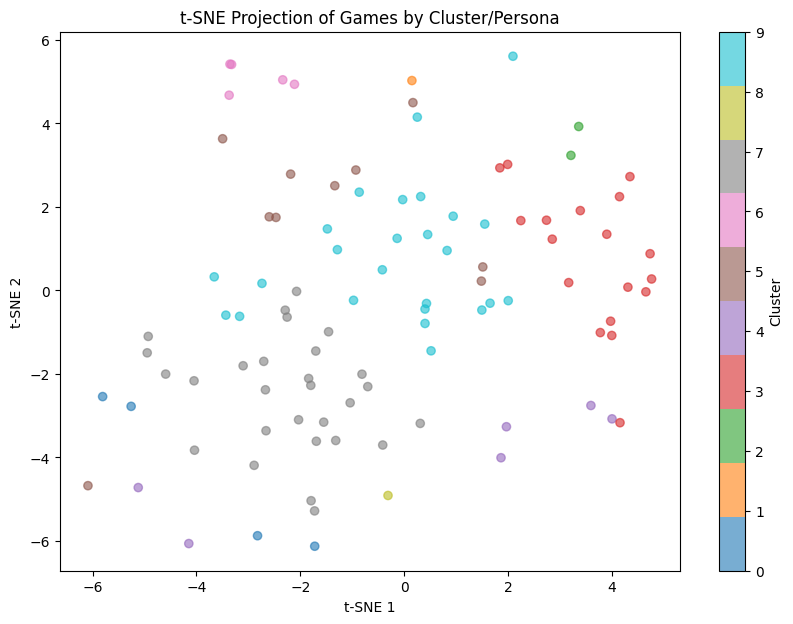

In [42]:
# Visualize games by cluster/persona
X = np.vstack(games_with_personas_pd['review_embedding_array'].values)

from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X)
games_with_personas_pd["x"] = X_tsne[:, 0]
games_with_personas_pd['y'] = X_tsne[:, 1]

plt.figure(figsize=(10,7))
scatter = plt.scatter(games_with_personas_pd['x'], games_with_personas_pd['y'], c=games_with_personas_pd["game_cluster"], cmap="tab10", alpha=0.6)
plt.title("t-SNE Projection of Games by Cluster/Persona")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(scatter, label="Cluster")
plt.show()

### Part 4.b.ii. Author Clusters Visualization

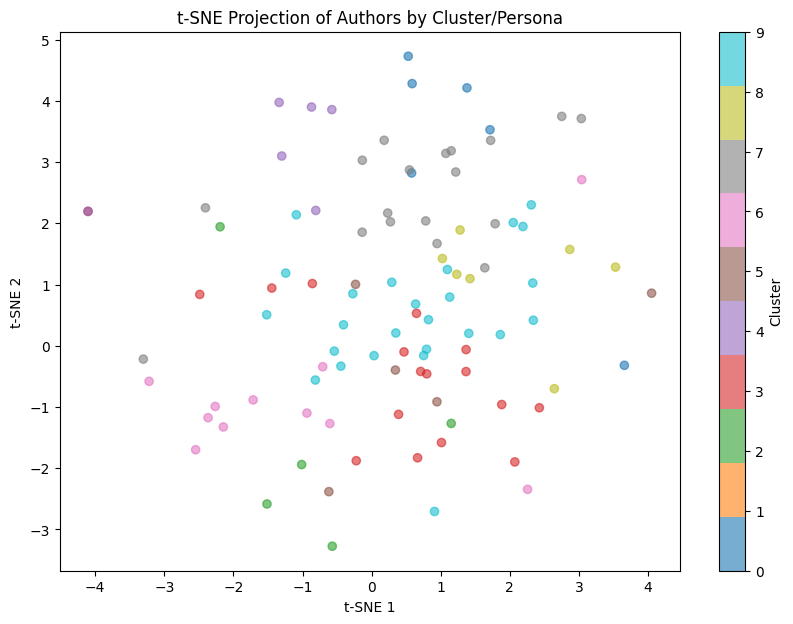

In [43]:
# Visualize Authors by Cluster/Persona
authors_with_personas_pd_ds = authors_with_personas_pd.sample(n=100, random_state=42)
X2 = np.vstack(authors_with_personas_pd_ds['review_embedding_array'].values)
X2_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X2)
authors_with_personas_pd_ds['x'] = X2_tsne[:, 0]
authors_with_personas_pd_ds['y'] = X2_tsne[:, 1]

plt.figure(figsize=(10,7))
scatter = plt.scatter(authors_with_personas_pd_ds['x'], authors_with_personas_pd_ds['y'], c=authors_with_personas_pd_ds["persona"], cmap="tab10", alpha=0.6)
plt.title("t-SNE Projection of Authors by Cluster/Persona")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(scatter, label="Cluster")
plt.show()

In [44]:
# Table view of game clusters
game_clusters_summarized_pd

,game_cluster,game_count,games_in_cluster
0,0,4,"[Five Nights at Freddy's, Garfield Kart, Yakuz..."
1,1,1,[The Elder Scrolls V: Skyrim]
2,3,15,"[The Witcher 3: Wild Hunt, Undertale, NieR:Aut..."
3,4,6,"[DOOM, Risk of Rain 2, ELDEN RING, Helltaker, ..."
4,5,8,"[Garry's Mod, Grand Theft Auto V Legacy, BeamN..."
5,6,5,"[Call of Duty®: Black Ops, Call of Duty®: Blac..."
6,7,27,"[DayZ, War Thunder, Papers, Please, Rust, RimW..."
7,8,1,[Deep Rock Galactic]
8,9,24,"[Team Fortress 2, Terraria, Euro Truck Simulat..."


# Part 5: Model #2 - Predicting a Game's Popularity

The goal of this model is to predict a game's popularity with Steam users by analyzing other provided metadata about the game. For this model, popularity is the positive_ratio of the game amongst Steam users leaving reviews, where 0 is all negative reviews and 1 is all positive reviews.

## Part 5.a. Feature Engineering

In [45]:
# Cast boolean features in the "reviews metadata" data frame to integer
review_pop_pred = reviews_df_processed_metadata.withColumn("positive_review", f.col("positive_review").cast("integer"))
review_pop_pred = review_pop_pred.withColumn("steam_purchase", f.col("steam_purchase").cast("integer"))

# Group the reviews metadata by game (app id) and aggregate specified features
review_pop_pred = review_pop_pred.groupBy("appid").agg(
                        f.avg("positive_review").alias("positive_ratio"),
                        f.avg("author_playtime_at_review").alias("avg_playtime_at_review"),
                        f.avg("steam_purchase").alias("steam_purchase_ratio"),
                        f.count("*").alias("total_reviews")
                    )
# Filter out games that have less than 100 reviews
review_pop_pred = review_pop_pred.filter("total_reviews >= 100")

# Join the review metadata with specified games metadata
review_pop_pred = review_pop_pred.join(games_df_processed.select("appid", "price", "metacritic_score", "dlc_count","average_playtime_forever", "median_playtime_forever",
                                                                 "peak_ccu"), on="appid", how="left")

# Join the metadata with the vectorized reviews
ML_df = review_pop_pred.join(game_features_df.select("appid", "vectorized_reviews_by_game"), on="appid", how="left")

ML_df.printSchema()
ML_df.count()
ML_df.show(5)

root
 |-- appid: integer (nullable = true)
 |-- positive_ratio: double (nullable = true)
 |-- avg_playtime_at_review: double (nullable = true)
 |-- steam_purchase_ratio: double (nullable = true)
 |-- total_reviews: long (nullable = false)
 |-- price: double (nullable = true)
 |-- metacritic_score: double (nullable = true)
 |-- dlc_count: integer (nullable = true)
 |-- average_playtime_forever: integer (nullable = true)
 |-- median_playtime_forever: integer (nullable = true)
 |-- peak_ccu: integer (nullable = true)
 |-- vectorized_reviews_by_game: vector (nullable = true)

+-------+------------------+----------------------+--------------------+-------------+-----+----------------+---------+------------------------+-----------------------+--------+--------------------------+
|  appid|    positive_ratio|avg_playtime_at_review|steam_purchase_ratio|total_reviews|price|metacritic_score|dlc_count|average_playtime_forever|median_playtime_forever|peak_ccu|vectorized_reviews_by_game|
+-------+--

In [46]:
# Identify Nulls
ML_df.select([count(when(col(c).isNull(), c)).alias(c) for c in ML_df.columns]).show()

+-----+--------------+----------------------+--------------------+-------------+-----+----------------+---------+------------------------+-----------------------+--------+--------------------------+
|appid|positive_ratio|avg_playtime_at_review|steam_purchase_ratio|total_reviews|price|metacritic_score|dlc_count|average_playtime_forever|median_playtime_forever|peak_ccu|vectorized_reviews_by_game|
+-----+--------------+----------------------+--------------------+-------------+-----+----------------+---------+------------------------+-----------------------+--------+--------------------------+
|    0|             0|                     0|                   0|            0|   33|              33|       33|                      47|                     39|      38|                       164|
+-----+--------------+----------------------+--------------------+-------------+-----+----------------+---------+------------------------+-----------------------+--------+--------------------------+



In [47]:
# Combine features into single "features" vector
numeric_cols = ['avg_playtime_at_review', 'steam_purchase_ratio', 'total_reviews', 'price', 'metacritic_score', 'dlc_count',
                'average_playtime_forever', 'median_playtime_forever', 'peak_ccu']

In [48]:
# Handle Nulls
for c in numeric_cols:
    ML_df = ML_df.withColumn(c, when(col(c).isNull(), 0).otherwise(col(c)))

@udf(VectorUDT())
def zero_vector_udf():
    return Vectors.dense([0.0] * 50)

ML_df = ML_df.withColumn("vectorized_reviews_by_game",
                         when(col("vectorized_reviews_by_game").isNull(), zero_vector_udf()).otherwise(col("vectorized_reviews_by_game")))

In [49]:
# Recheck Nulls
ML_df.select([count(when(col(c).isNull(), c)).alias(c) for c in ML_df.columns]).show()

+-----+--------------+----------------------+--------------------+-------------+-----+----------------+---------+------------------------+-----------------------+--------+--------------------------+
|appid|positive_ratio|avg_playtime_at_review|steam_purchase_ratio|total_reviews|price|metacritic_score|dlc_count|average_playtime_forever|median_playtime_forever|peak_ccu|vectorized_reviews_by_game|
+-----+--------------+----------------------+--------------------+-------------+-----+----------------+---------+------------------------+-----------------------+--------+--------------------------+
|    0|             0|                     0|                   0|            0|    0|               0|        0|                       0|                      0|       0|                         0|
+-----+--------------+----------------------+--------------------+-------------+-----+----------------+---------+------------------------+-----------------------+--------+--------------------------+



In [50]:
# Assemble Numeric Columns and Vector into a single features vector
assembler = VectorAssembler(
    inputCols=numeric_cols + ['vectorized_reviews_by_game'], outputCol='features'
)

## Part 5.b. Random Forest Regressor Model

In [51]:
# Establish Random Forest Regressor
rf = RandomForestRegressor(
    featuresCol='features',
    labelCol='positive_ratio',
    predictionCol='prediction',
    numTrees=100,
    maxDepth=10,
    seed=96
)

In [52]:
# Establish ML pipeline
pipeline = Pipeline(stages=[assembler, rf])

In [53]:
# Split into training and test data
train_data, test_data = ML_df.randomSplit([0.8, 0.2], seed=96)

In [54]:
# Train model
model = pipeline.fit(train_data)

In [55]:
# Evaluate model
predictions = model.transform(test_data)

evaluator = RegressionEvaluator(
    labelCol='positive_ratio',
    predictionCol='prediction',
    metricName='rmse'
)

rmse = evaluator.evaluate(predictions)
r2 = RegressionEvaluator(labelCol='positive_ratio', predictionCol='prediction', metricName='r2').evaluate(predictions)

print("RMSE: ", rmse)
print("R^2 Score: ", r2)

RMSE:  0.19402034057545026
R^2 Score:  0.14361506823508985
